In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pickle


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


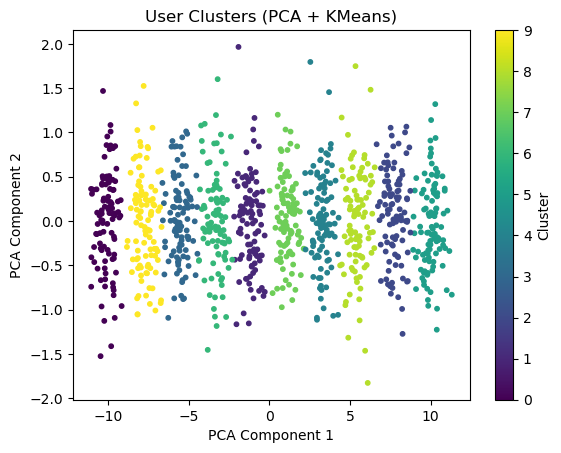

Model Accuracy: 0.96


In [5]:

# Step 1: Generate synthetic data for users
np.random.seed(42)
num_users = 10
num_samples = 100
num_features = 5

# Create a synthetic dataset where users have distinct but overlapping patterns
data = []
labels = []
for user in range(num_users):
    user_data = np.random.normal(loc=user, scale=0.5, size=(num_samples, num_features))
    data.append(user_data)
    labels.append(np.full(num_samples, user))  # Labels are user IDs

data = np.vstack(data)
labels = np.hstack(labels)

# Step 2: Perform dimensionality reduction to find shared structure
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)

# Step 3: Cluster users based on reduced dimensions
kmeans = KMeans(n_clusters=num_users)
user_clusters = kmeans.fit_predict(data_reduced)

# Visualize the clusters
import matplotlib.pyplot as plt

plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=user_clusters, cmap='viridis', s=10)
plt.title("User Clusters (PCA + KMeans)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Step 4: Train a classification model to generalize across users
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

#clf = LogisticRegression(max_iter=1000)
clf = SVC(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Save clusters for further analysis
#cluster_df = pd.DataFrame({
#    'User_ID': np.repeat(range(num_users), num_samples),
#    'Cluster': np.repeat(user_clusters, num_samples // num_users)
#})
# Correct the number of clusters to match user data
cluster_df = pd.DataFrame({
    'User_ID': np.repeat(range(num_users), num_samples),
    'Cluster': user_clusters[:num_users * num_samples]  # Truncate if necessary
})



# Using My Dataset

In [8]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)

print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 2: Aggregate rows into matrices per gesture
def aggregate_gesture_data(group):
    # Convert the 64 rows into a 16x64 matrix
    matrix = group.iloc[:, 3:].to_numpy().T
    return pd.Series({
        "Matrix": matrix.flatten(),  # Flatten 16x64 into 1D array
        "Gesture_ID": group["Gesture_ID"].iloc[0]  # Keep the label
    })

grouped_df = raw_userdef_data_df.groupby(["Participant", "Gesture_ID", "Gesture_Num"]).apply(aggregate_gesture_data)
X = np.vstack(grouped_df["Matrix"].values)
y = grouped_df["Gesture_ID"].values

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Step 5: Train a simple classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Step 7: Decode predicted labels (optional)
decoded_labels = label_encoder.inverse_transform(y_pred)


Model Accuracy: 26.77%
